# Parkinson's Telemonitoring Score Estimation
### Final Project - EE8603
___
Toronto Metropolitan University

Instructor’s name: Dr. Ghassem Tofighi

Student name: Abbdullah Madni
Student #: 500651269

Python ver. 3.10.13

In [1]:
%pip install pycaret[full]
%pip install ucimlrepo
%pip install pylance
%pip install scikit-learn
%pip install joblib

from ucimlrepo import fetch_ucirepo
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pycaret

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import  mean_absolute_error as mae

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

# fetch dataset 
parkinsons_telemonitoring = fetch_ucirepo(id=189)
  
# data (as pandas dataframes) 
x_feat = parkinsons_telemonitoring.data.features
y_tar = parkinsons_telemonitoring.data.targets
  
# metadata 
# print(parkinsons_telemonitoring.metadata)
  
# variable information
z = parkinsons_telemonitoring.variables

  Using cached pyarrow-6.0.1-cp310-cp310-win_amd64.whl (15.5 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.1
    Uninstalling pyarrow-14.0.1:
      Successfully uninstalled pyarrow-14.0.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylance 0.8.17 requires pyarrow>=10, but you have pyarrow 6.0.1 which is incompatible.


Note: you may need to restart the kernel to use updated packages.
  Using cached pyarrow-14.0.1-cp310-cp310-win_amd64.whl.metadata (3.1 kB)
Using cached pyarrow-14.0.1-cp310-cp310-win_amd64.whl (24.6 MB)
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 6.0.1
    Uninstalling pyarrow-6.0.1:
      Successfully uninstalled pyarrow-6.0.1
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


#### Data Cleanup

In [2]:
x_feat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5875 entries, 0 to 5874
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            5875 non-null   int64  
 1   test_time      5875 non-null   float64
 2   Jitter(%)      5875 non-null   float64
 3   Jitter(Abs)    5875 non-null   float64
 4   Jitter:RAP     5875 non-null   float64
 5   Jitter:PPQ5    5875 non-null   float64
 6   Jitter:DDP     5875 non-null   float64
 7   Shimmer        5875 non-null   float64
 8   Shimmer(dB)    5875 non-null   float64
 9   Shimmer:APQ3   5875 non-null   float64
 10  Shimmer:APQ5   5875 non-null   float64
 11  Shimmer:APQ11  5875 non-null   float64
 12  Shimmer:DDA    5875 non-null   float64
 13  NHR            5875 non-null   float64
 14  HNR            5875 non-null   float64
 15  RPDE           5875 non-null   float64
 16  DFA            5875 non-null   float64
 17  PPE            5875 non-null   float64
 18  sex     

In [3]:
#check for duplicate rows
x_feat.duplicated().sum()
#replace empty entries with nan
x_feat = x_feat.replace({'':np.nan})
#add target column to data
x_feat['total_UPDRS'] = y_tar['total_UPDRS']
#drop motor_UPDRS since it is not relevant
y_tar.drop(['motor_UPDRS'], axis=1, inplace=True)

In [4]:
#find nan indices
#nan_in = np.argwhere(np.isnan(y_tar))
#nan_in = y_tar.loc[y_tar['total_UPDRS']==np.nan].index

#drop nan indices
#y_tar.drop(nan_in, inplace=True)
#x_feat.drop(nan_in, axis=0, inplace=True)

x_feat.dropna(subset='total_UPDRS', inplace=True)
y_tar.dropna(subset='total_UPDRS', inplace=True)

In [5]:
x_feat.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,total_UPDRS
count,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000,5875.000000
mean,64.804936,92.863722,0.006154,0.000044,0.002987,0.003277,0.008962,0.034035,0.310960,0.017156,0.020144,0.027481,0.051467,0.032120,21.679495,0.541473,0.653240,0.219589,0.317787,29.018942
std,8.821524,53.445602,0.005624,0.000036,0.003124,0.003732,0.009371,0.025835,0.230254,0.013237,0.016664,0.019986,0.039711,0.059692,4.291096,0.100986,0.070902,0.091498,0.465656,10.700283
min,36.000000,-4.262500,0.000830,0.000002,0.000330,0.000430,0.000980,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000,7.000000
25%,58.000000,46.847500,0.003580,0.000022,0.001580,0.001820,0.004730,0.019120,0.175000,0.009280,0.010790,0.015665,0.027830,0.010955,19.406000,0.469785,0.596180,0.156340,0.000000,21.371000
50%,65.000000,91.523000,0.004900,0.000034,0.002250,0.002490,0.006750,0.027510,0.253000,0.013700,0.015940,0.022710,0.041110,0.018448,21.920000,0.542250,0.643600,0.205500,0.000000,27.576000
75%,72.000000,138.445000,0.006800,0.000053,0.003290,0.003460,0.009870,0.039750,0.365000,0.020575,0.023755,0.032715,0.061735,0.031463,24.444000,0.614045,0.711335,0.264490,1.000000,36.399000
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,1.000000,54.992000


In [6]:
y_tar.describe()

,total_UPDRS
count,5875.000000
mean,29.018942
std,10.700283
min,7.000000
25%,21.371000
50%,27.576000
75%,36.399000
max,54.992000


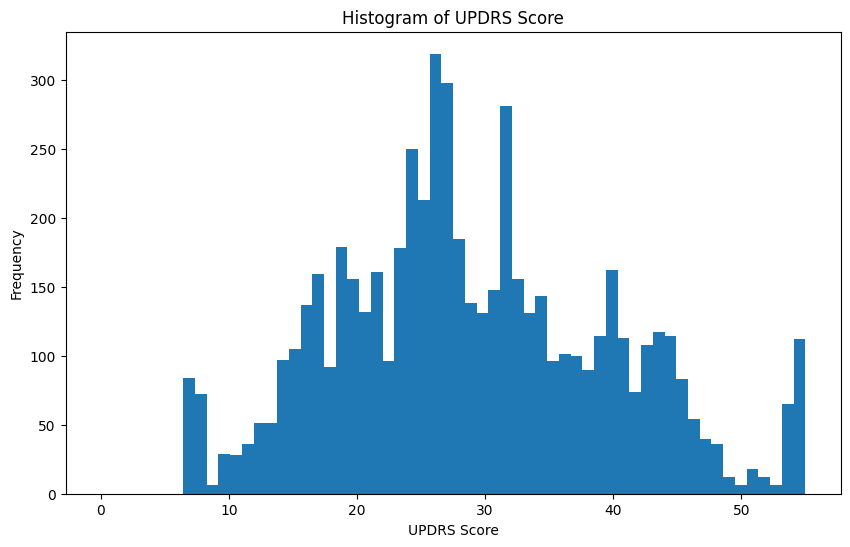

In [7]:
#plotting total_UPDRS score to see outliers
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(y_tar['total_UPDRS'], bins=60, range=(0,55))
ax.set_title("Histogram of UPDRS Score")
ax.set_xlabel('UPDRS Score')
ax.set_ylabel('Frequency')
plt.show()

In [8]:
lower_bnd = y_tar.loc[y_tar['total_UPDRS']<=10].index
upper_bnd = y_tar.loc[y_tar['total_UPDRS']>=50].index
#dropping score values below 10 and above 50 for better training
y_tar.drop(lower_bnd, inplace=True)
y_tar.drop(upper_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)
x_feat.drop(upper_bnd, axis=0, inplace=True)

In [9]:
y_tar['total_UPDRS'] = y_tar['total_UPDRS'].astype(float)

y_tar.describe()

,total_UPDRS
count,5471.000000
mean,28.796866
std,9.120964
min,10.324000
25%,21.903000
50%,27.490000
75%,35.192000
max,49.885000


In [10]:
#checking for na values
(np.mean(x_feat.isna()).sort_values(ascending = False))*100

age              0.0
test_time        0.0
sex              0.0
PPE              0.0
DFA              0.0
RPDE             0.0
HNR              0.0
NHR              0.0
Shimmer:DDA      0.0
Shimmer:APQ11    0.0
Shimmer:APQ5     0.0
Shimmer:APQ3     0.0
Shimmer(dB)      0.0
Shimmer          0.0
Jitter:DDP       0.0
Jitter:PPQ5      0.0
Jitter:RAP       0.0
Jitter(Abs)      0.0
Jitter(%)        0.0
total_UPDRS      0.0
dtype: float64

In [11]:
x_feat.describe()

,age,test_time,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,sex,total_UPDRS
count,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000,5471.000000
mean,64.703528,92.342514,0.006247,0.000045,0.003037,0.003326,0.009112,0.034212,0.312541,0.017257,0.020250,0.027535,0.051770,0.033285,21.602749,0.545357,0.652265,0.220233,0.329373,28.796866
std,8.790047,53.548202,0.005780,0.000037,0.003211,0.003846,0.009632,0.026424,0.235272,0.013524,0.017062,0.020350,0.040572,0.061600,4.320764,0.100393,0.071419,0.092488,0.470029,9.120964
min,36.000000,-4.262500,0.000830,0.000002,0.000340,0.000430,0.001030,0.003060,0.026000,0.001610,0.001940,0.002490,0.004840,0.000286,1.659000,0.151020,0.514040,0.021983,0.000000,10.324000
25%,58.000000,45.664000,0.003580,0.000023,0.001580,0.001830,0.004730,0.019095,0.175000,0.009270,0.010775,0.015685,0.027805,0.011114,19.338000,0.475510,0.594930,0.156860,0.000000,21.903000
50%,65.000000,91.304000,0.004930,0.000035,0.002270,0.002490,0.006810,0.027430,0.252000,0.013700,0.015830,0.022620,0.041100,0.019034,21.914000,0.546780,0.641800,0.204950,0.000000,27.490000
75%,72.000000,138.445000,0.006890,0.000055,0.003360,0.003520,0.010070,0.039775,0.366000,0.020610,0.023780,0.032695,0.061840,0.032330,24.400500,0.616365,0.709460,0.265550,1.000000,35.192000
max,85.000000,215.490000,0.099990,0.000446,0.057540,0.069560,0.172630,0.268630,2.107000,0.162670,0.167020,0.275460,0.488020,0.748260,37.875000,0.966080,0.865600,0.731730,1.000000,49.885000


In [12]:
#dropping total_UPDRS from x data
x_feat.drop('total_UPDRS', axis=1, inplace=True)

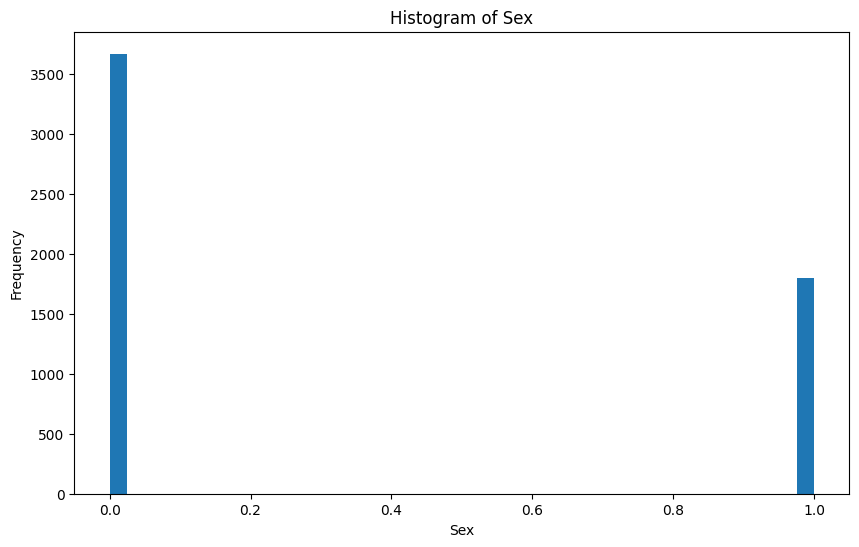

In [13]:
#looking at sex
fig, ax = plt.subplots(figsize=(10,6))
ax.hist(x_feat['sex'], bins=40)
ax.set_title("Histogram of Sex")
ax.set_xlabel('Sex')
ax.set_ylabel('Frequency')
plt.show()

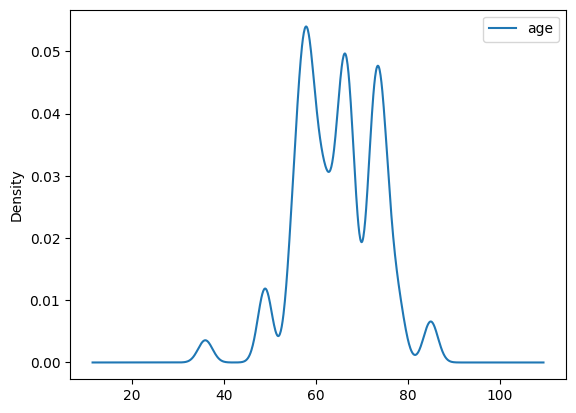

In [14]:
#looking at age
pd.DataFrame(x_feat.age).plot(kind="density")
plt.show()

We can see that most of the patients are between 50 years and 80 years. This coincides with Parkinson's disease known facts.

In [15]:
#remove all entries below 45 years of age to reduce outlier
lower_bnd = x_feat.loc[x_feat['age']<=45].index
#dropping score values below 10 and above 50 for better training
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

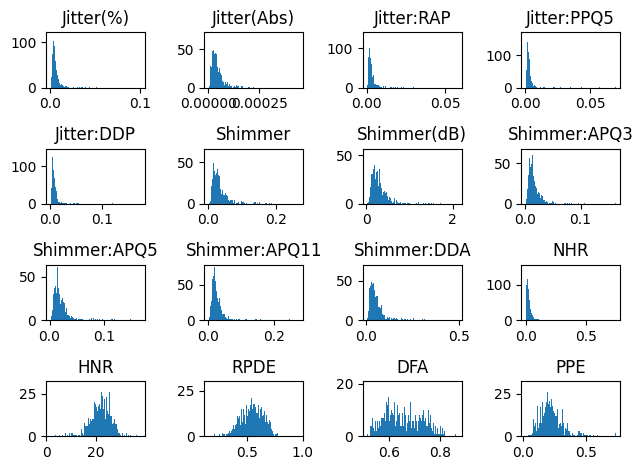

In [16]:
n_bins = 1000
fig,axes = plt.subplots(4,4)
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 = axes.flatten()

ax0.hist(x_feat["Jitter(%)"], n_bins)
ax0.set_title('Jitter(%)')

ax1.hist(x_feat["Jitter(Abs)"], n_bins)
ax1.set_title('Jitter(Abs)')

ax2.hist(x_feat["Jitter:RAP"], n_bins)
ax2.set_title('Jitter:RAP')

ax3.hist(x_feat["Jitter:PPQ5"], n_bins)
ax3.set_title('Jitter:PPQ5')

ax4.hist(x_feat["Jitter:DDP"], n_bins)
ax4.set_title('Jitter:DDP')

ax5.hist(x_feat["Shimmer"], n_bins)
ax5.set_title('Shimmer')

ax6.hist(x_feat["Shimmer(dB)"], n_bins)
ax6.set_title('Shimmer(dB)')

ax7.hist(x_feat["Shimmer:APQ3"], n_bins)
ax7.set_title('Shimmer:APQ3')

ax8.hist(x_feat["Shimmer:APQ5"], n_bins)
ax8.set_title('Shimmer:APQ5')

ax9.hist(x_feat["Shimmer:APQ11"], n_bins)
ax9.set_title('Shimmer:APQ11')

ax10.hist(x_feat["Shimmer:DDA"], n_bins)
ax10.set_title('Shimmer:DDA')

ax11.hist(x_feat["NHR"], n_bins)
ax11.set_title('NHR')

ax12.hist(x_feat["HNR"], n_bins)
ax12.set_title('HNR')

ax13.hist(x_feat["RPDE"], n_bins)
ax13.set_title('RPDE')

ax14.hist(x_feat["DFA"], n_bins)
ax14.set_title('DFA')

ax15.hist(x_feat["PPE"], n_bins)
ax15.set_title('PPE')

#x_feat["Jitter(%)"].hist(ax=axes[0])
#x_feat["Jitter(Abs)"].hist(ax=axes[1])

fig.tight_layout()
plt.show()

We can see that the features are not normalized and outliers might affect the training ML models.

In [17]:
#dropping indices at extreme values to normalize data
lower_bnd = x_feat.loc[x_feat['Jitter(%)']>=0.01].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Jitter(Abs)']>=0.0001].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Jitter:RAP']>=0.005].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Jitter:PPQ5']>=0.00375].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Jitter:DDP']>=0.02].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Shimmer']>=0.1].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Shimmer(dB)']>=0.5].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)
lower_bnd = x_feat.loc[x_feat['Shimmer:APQ3']>=0.05].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Shimmer:APQ5']>=0.05].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Shimmer:APQ11']>=0.066].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['Shimmer:DDA']>=0.125].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['NHR']>=0.05].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[(x_feat['HNR']>=30)].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[(x_feat['HNR']<=10)].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[(x_feat['RPDE']>=0.75)].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[(x_feat['RPDE']<=0.25)].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['DFA']>=0.8].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)

lower_bnd = x_feat.loc[x_feat['PPE']>=0.5].index
y_tar.drop(lower_bnd, inplace=True)
x_feat.drop(lower_bnd, axis=0, inplace=True)



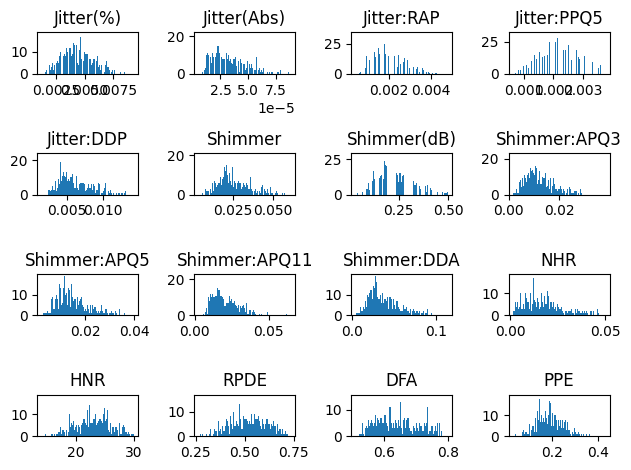

In [18]:
#replotting new dataset
n_bins = 1000
fig,axes = plt.subplots(4,4)
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11, ax12, ax13, ax14, ax15 = axes.flatten()

ax0.hist(x_feat["Jitter(%)"], n_bins)
ax0.set_title('Jitter(%)')

ax1.hist(x_feat["Jitter(Abs)"], n_bins)
ax1.set_title('Jitter(Abs)')

ax2.hist(x_feat["Jitter:RAP"], n_bins)
ax2.set_title('Jitter:RAP')

ax3.hist(x_feat["Jitter:PPQ5"], n_bins)
ax3.set_title('Jitter:PPQ5')

ax4.hist(x_feat["Jitter:DDP"], n_bins)
ax4.set_title('Jitter:DDP')

ax5.hist(x_feat["Shimmer"], n_bins)
ax5.set_title('Shimmer')

ax6.hist(x_feat["Shimmer(dB)"], n_bins)
ax6.set_title('Shimmer(dB)')

ax7.hist(x_feat["Shimmer:APQ3"], n_bins)
ax7.set_title('Shimmer:APQ3')

ax8.hist(x_feat["Shimmer:APQ5"], n_bins)
ax8.set_title('Shimmer:APQ5')

ax9.hist(x_feat["Shimmer:APQ11"], n_bins)
ax9.set_title('Shimmer:APQ11')

ax10.hist(x_feat["Shimmer:DDA"], n_bins)
ax10.set_title('Shimmer:DDA')

ax11.hist(x_feat["NHR"], n_bins)
ax11.set_title('NHR')

ax12.hist(x_feat["HNR"], n_bins)
ax12.set_title('HNR')

ax13.hist(x_feat["RPDE"], n_bins)
ax13.set_title('RPDE')

ax14.hist(x_feat["DFA"], n_bins)
ax14.set_title('DFA')

ax15.hist(x_feat["PPE"], n_bins)
ax15.set_title('PPE')

fig.tight_layout()
plt.show()

In [19]:
#x_tt = x_feat.drop(['age','test_time','sex'],axis=1)

#dropping test_time from features because it is irrelevant
x_tt = x_feat.drop(['test_time'],axis=1)

#### Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
# Create the regressor: reg
reg = LinearRegression()

# Compute predictions over the prediction space: y_pred
X_train, X_test, y_train, y_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Print R^2
print("R^2 score:", reg.score(x_tt, y_tar))


R^2 score: 0.15060203611076906


Scaling data

In [21]:
scaler = StandardScaler()
scaler.fit(X_train)
X_lm_train = scaler.transform(X_train)
X_lm_test = scaler.transform(X_test)

reg = LinearRegression()

# Compute predictions over the prediction space: y_pred
X_train, X_test, y_train, y_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

# Print R^2
print("R^2 score:", reg.score(x_tt, y_tar))

R^2 score: 0.15060203611076906


The accuracy is very poor for just Linear Regression so we will look at other ML models.

### Ridge Regression

In [22]:
# Let's split our dataframe into train and test sets:
X_rrcv_train, X_rrcv_test, y_rrcv_train, y_rrcv_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_rrcv_train shape:', X_rrcv_train.shape)
print('y_rrcv_train shape:', y_rrcv_train.shape)
print('X_rrcv_test shape:', X_rrcv_test.shape)
print('y_rrcv_test shape:', y_rrcv_test.shape)
print("--------------------------------------------------------------------------------------------------------------------------------")

# 1. Instantiate the model:
myRRCV = RidgeCV(cv=5)

# 2. Fit the model:
myRRCV.fit(X_rrcv_train, y_rrcv_train)

# 3. Make prediction (will use it for mae):
y_rrcv_test_pred = myRRCV.predict(X_rrcv_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_rrcv_test, y_rrcv_test_pred))
print("The mean value of the price column is: ", y_rrcv_test.mean())
print("The train set R^2 of our model is: ", round(myRRCV.score(X_rrcv_train,y_rrcv_train),4))
print("The test set R^2 of our model is: ", round(myRRCV.score(X_rrcv_test,y_rrcv_test),4))

X_rrcv_train shape: (3066, 18)
y_rrcv_train shape: (3066, 1)
X_rrcv_test shape: (767, 18)
y_rrcv_test shape: (767, 1)
--------------------------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  7.372702090605425
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1391
The test set R^2 of our model is:  0.1302


The accuracy is still not satisfactory so we will move onto Lasso Regression.

### Lasso Regression 

In [23]:
# ScikitLearn Lasso Regression:

# Let's split our dataframe into train and test sets:
X_lr_train, X_lr_test, y_lr_train, y_lr_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_lr_train shape:', X_lr_train.shape)
print('y_lr_train shape:', y_lr_train.shape)
print('X_lr_test shape:', X_lr_test.shape)
print('y_lr_test shape:', y_lr_test.shape)
print("--------------------------------------------------------------------------------------------------------------------------------")

# 1. Instantiate the model:
myLasso = Lasso(alpha=0.001)

# 2. Fit the model:
myLasso.fit(X_lr_train, y_lr_train)

# 3. Make prediction (will use it for mae):
y_lr_test_pred = myLasso.predict(X_lr_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_lr_test, y_lr_test_pred))
print("The mean value of the price column is: ", y_lr_test.mean())
print("The train set R^2 of our model is: ", round(myLasso.score(X_lr_train,y_lr_train),4))
print("The test set R^2 of our model is: ", round(myLasso.score(X_lr_test,y_lr_test),4))

X_lr_train shape: (3066, 18)
y_lr_train shape: (3066, 1)
X_lr_test shape: (767, 18)
y_lr_test shape: (767, 1)
--------------------------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  7.368615668683363
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1402
The test set R^2 of our model is:  0.1312


In [24]:
# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_lr_train)
X_lr_train = scaler.transform(X_lr_train)
X_lr_test = scaler.transform(X_lr_test)

# 1. Instantiate the model:
myLasso = Lasso(alpha=0.001, max_iter=10000)

# 2. Fit the model:
myLasso.fit(X_lr_train, y_lr_train)

# 3. Make prediction (will use it for mae):
y_lr_test_pred = myLasso.predict(X_lr_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_lr_test, y_lr_test_pred))
print("The mean value of the price column is: ", y_lr_test.mean())
print("The train set R^2 of our model is: ", round(myLasso.score(X_lr_train,y_lr_train),4))
print("The test set R^2 of our model is: ", round(myLasso.score(X_lr_test,y_lr_test),4))

The mean absolute error of our model is:  7.260851136785893
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1506
The test set R^2 of our model is:  0.1497


In [25]:
train_scores_lr = []
test_scores_lr = []

alpha_values = [0.001, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10] 

for a in alpha_values:
    
    myLasso = Lasso(alpha=a)
    myLasso.fit(X_lr_train, y_lr_train)
    
    train_scores_lr.append(myLasso.score(X_lr_train,y_lr_train))
    test_scores_lr.append(myLasso.score(X_lr_test,y_lr_test))
    
    print(f'Train set R^2 score with alpha={a}: {myLasso.score(X_lr_train,y_lr_train)}')
    print(f'Validation set R^2 score with alpha={a}: {myLasso.score(X_lr_test,y_lr_test)}')
    print()

Train set R^2 score with alpha=0.001: 0.15063230657640392
Validation set R^2 score with alpha=0.001: 0.1498599750592572

Train set R^2 score with alpha=0.01: 0.14991741372397815
Validation set R^2 score with alpha=0.01: 0.1473162920270069

Train set R^2 score with alpha=0.05: 0.14678268258324845
Validation set R^2 score with alpha=0.05: 0.14101629662468873

Train set R^2 score with alpha=0.1: 0.1435913049018246
Validation set R^2 score with alpha=0.1: 0.1361465596193162

Train set R^2 score with alpha=0.2: 0.13762106603691016
Validation set R^2 score with alpha=0.2: 0.12987371194574193

Train set R^2 score with alpha=0.4: 0.1296904774650065
Validation set R^2 score with alpha=0.4: 0.1217977495835969

Train set R^2 score with alpha=0.6: 0.11895896092640723
Validation set R^2 score with alpha=0.6: 0.11134991735204047

Train set R^2 score with alpha=0.8: 0.10731697556263797
Validation set R^2 score with alpha=0.8: 0.10093037015047801

Train set R^2 score with alpha=1: 0.09474926457938926


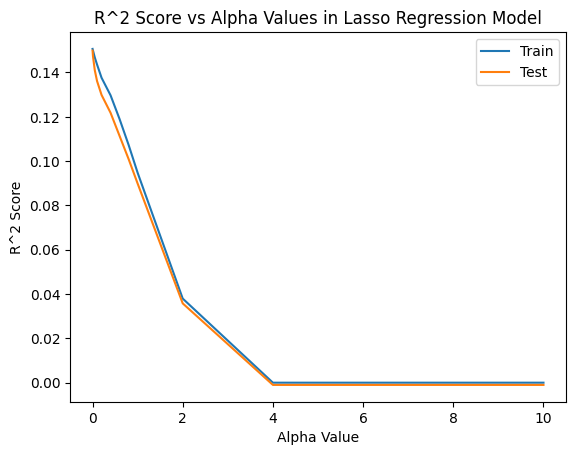

In [26]:
# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs Alpha Values in Lasso Regression Model")
plt.plot(alpha_values, train_scores_lr, label="Train")
plt.plot(alpha_values, test_scores_lr, label="Test")
plt.legend()
plt.xlabel("Alpha Value")
plt.ylabel("R^2 Score")
plt.show()

### LassoCV Regression 

In [27]:
# ScikitLearn LassoCV Regression (default values):

X_lrcv_train, X_lrcv_test, y_lrcv_train, y_lrcv_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_lrcv_train)
X_lrcv_train = scaler.transform(X_lrcv_train)
X_lrcv_test = scaler.transform(X_lrcv_test)

# 1. Instantiate the model:
myLassoCV = LassoCV()

# 2. Fit the model:
myLassoCV.fit(X_lrcv_train, y_lrcv_train)

# 3. Make prediction (will use it for mae):
y_lrcv_test_pred = myLassoCV.predict(X_lrcv_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_lrcv_test, y_lrcv_test_pred))
print("The mean value of the price column is: ", y_lrcv_test.mean())
print("The train set R^2 of our model is: ", round(myLassoCV.score(X_lrcv_train,y_lrcv_train),4))
print("The test set R^2 of our model is: ", round(myLassoCV.score(X_lrcv_test,y_lrcv_test),4))

The mean absolute error of our model is:  7.263849480628938
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1506
The test set R^2 of our model is:  0.1493


In [28]:
# ScikitLearn LassoCV Regression (custom values):

# 1. Instantiate the model:
myLassoCV = LassoCV(cv=5, random_state=1)

# 2. Fit the model:
myLassoCV.fit(X_lrcv_train, y_lrcv_train)

# 3. Make prediction (will use it for mae):
y_lrcv_test_pred = myLassoCV.predict(X_lrcv_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_lrcv_test, y_lrcv_test_pred))
print("The mean value of the price column is: ", y_lrcv_test.mean())
print("The train set R^2 of our model is: ", round(myLassoCV.score(X_lrcv_train,y_lrcv_train),4))
print("The test set R^2 of our model is: ", round(myLassoCV.score(X_lrcv_test,y_lrcv_test),4))

The mean absolute error of our model is:  7.263849480628938
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1506
The test set R^2 of our model is:  0.1493


In [29]:
# Let's view the best alpha value:
print('Best alpha value is: ', myLassoCV.alpha_)

Best alpha value is:  0.0026706601111675704


### Elastic Regression 

In [30]:
# ScikitLearn Elastic Regression (default values):

X_elr_train, X_elr_test, y_elr_train, y_elr_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_elr_train shape:', X_elr_train.shape)
print('y_elr_train shape:', y_elr_train.shape)
print('X_elr_test shape:', X_elr_test.shape)
print('y_elr_test shape:', y_elr_test.shape)
print("--------------------------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_elr_train)
X_elr_train = scaler.transform(X_elr_train)
X_elr_test = scaler.transform(X_elr_test)

# 1. Instantiate the model:
myER = ElasticNet()

# 2. Fit the model:
myER.fit(X_elr_train, y_elr_train)

# 3. Make prediction (will use it for mae):
y_elr_test_pred = myER.predict(X_elr_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_elr_test, y_elr_test_pred))
print("The mean value of the price column is: ", y_elr_test.mean())
print("The train set R^2 of our model is: ", round(myER.score(X_elr_train,y_elr_train),4))
print("The test set R^2 of our model is: ", round(myER.score(X_elr_test,y_elr_test),4))

X_elr_train shape: (3066, 18)
y_elr_train shape: (3066, 1)
X_elr_test shape: (767, 18)
y_elr_test shape: (767, 1)
--------------------------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  7.536801744731516
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1005
The test set R^2 of our model is:  0.0947


Train set R^2 score with alpha=0.0001: 0.15063511132197538
Validation set R^2 score with alpha=0.0001: 0.14986612689946743

Train set R^2 score with alpha=0.0005: 0.15063026420357517
Validation set R^2 score with alpha=0.0005: 0.14974213732215258

Train set R^2 score with alpha=0.001: 0.15061735374944185
Validation set R^2 score with alpha=0.001: 0.14958834145526434

Train set R^2 score with alpha=0.005: 0.150376718965044
Validation set R^2 score with alpha=0.005: 0.14845708352584286

Train set R^2 score with alpha=0.01: 0.14998543339999215
Validation set R^2 score with alpha=0.01: 0.1473000255565342

Train set R^2 score with alpha=0.05: 0.14750148752176606
Validation set R^2 score with alpha=0.05: 0.14234960772781413

Train set R^2 score with alpha=0.1: 0.1446245081078278
Validation set R^2 score with alpha=0.1: 0.13855954181137042

Train set R^2 score with alpha=0.2: 0.13907853715487162
Validation set R^2 score with alpha=0.2: 0.1323472222847062

Train set R^2 score with alpha=0.4: 0

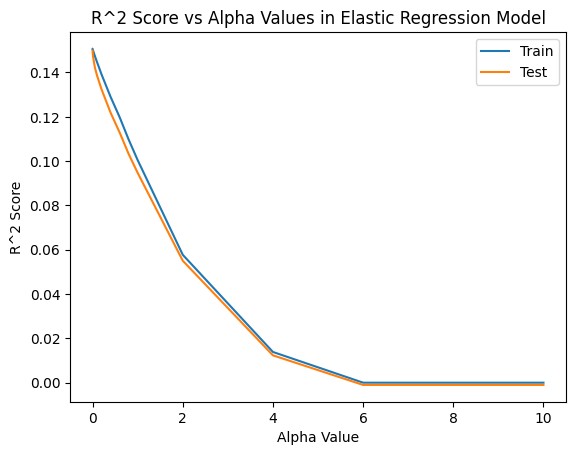

In [31]:
# Let's now run the Elastic Regression model (max_iter=10,000) with different alpha values and see how our R^2 scores change:
train_scores_er = []
test_scores_er = []

alpha_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.4, 0.6, 0.8, 1, 2, 4, 6, 8, 10] 

for a in alpha_values:
    
    myER = ElasticNet(alpha=a, max_iter=10000)
    myER.fit(X_elr_train, y_elr_train)
    
    train_scores_er.append(myER.score(X_elr_train,y_elr_train))
    test_scores_er.append(myER.score(X_elr_test,y_elr_test))
    
    print(f'Train set R^2 score with alpha={a}: {myER.score(X_elr_train,y_elr_train)}')
    print(f'Validation set R^2 score with alpha={a}: {myER.score(X_elr_test,y_elr_test)}')
    print()
    

# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs Alpha Values in Elastic Regression Model")
plt.plot(alpha_values, train_scores_er, label="Train")
plt.plot(alpha_values, test_scores_er, label="Test")
plt.legend()
plt.xlabel("Alpha Value")
plt.ylabel("R^2 Score")
plt.show()

This accuracy is still not suitable for us.

### KNN Regression 

In [32]:
# ScikitLearn KNN Regression (default values):

X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_knn_train shape:', X_knn_train.shape)
print('y_knn_train shape:', y_knn_train.shape)
print('X_knn_test shape:', X_knn_test.shape)
print('y_knn_test shape:', y_knn_test.shape)
print("---------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_knn_train)
X_knn_train = scaler.transform(X_knn_train)
X_knn_test = scaler.transform(X_knn_test)

# 1. Instantiate the model:
myKNN = KNeighborsRegressor()

# 2. Fit the model:
myKNN.fit(X_knn_train, y_knn_train)

# 3. Make prediction (will use it for mae):
y_knn_test_pred = myKNN.predict(X_knn_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_knn_test, y_knn_test_pred))
print("The mean value of the price column is: ", y_knn_test.mean())
print("The train set R^2 of our model is: ", round(myKNN.score(X_knn_train,y_knn_train),4))
print("The test set R^2 of our model is: ", round(myKNN.score(X_knn_test,y_knn_test),4))

# Saving our model:
joblib.dump(myKNN, 'myKNN.pkl')

X_knn_train shape: (3066, 18)
y_knn_train shape: (3066, 1)
X_knn_test shape: (767, 18)
y_knn_test shape: (767, 1)
---------------------------------------------------------------
The mean absolute error of our model is:  4.637168970013038
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.7019
The test set R^2 of our model is:  0.5527


['myKNN.pkl']

We can see the KNN Regression has provided the best R^2 score so far.

#### KNN Regression: Hyperparameter Optimization

In [33]:
# ScikitLearn KNN Regression (weights='distance'):

# Let's split our dataframe into train and test sets:
X_knn_train, X_knn_test, y_knn_train, y_knn_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_knn_train shape:', X_knn_train.shape)
print('y_knn_train shape:', y_knn_train.shape)
print('X_knn_test shape:', X_knn_test.shape)
print('y_knn_test shape:', y_knn_test.shape)
print("---------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_knn_train)
X_knn_train = scaler.transform(X_knn_train)
X_knn_test = scaler.transform(X_knn_test)

# 1. Instantiate the model:
myKNN = KNeighborsRegressor(weights='distance')

# 2. Fit the model:
myKNN.fit(X_knn_train, y_knn_train)

# 3. Make prediction (will use it for mae):
y_knn_test_pred = myKNN.predict(X_knn_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_knn_test, y_knn_test_pred))
print("The mean value of the price column is: ", y_knn_test.mean())
print("The train set R^2 of our model is: ", round(myKNN.score(X_knn_train,y_knn_train),4))
print("The test set R^2 of our model is: ", round(myKNN.score(X_knn_test,y_knn_test),4))

joblib.dump(myKNN, 'myKNN_weights.pkl')

X_knn_train shape: (3066, 18)
y_knn_train shape: (3066, 1)
X_knn_test shape: (767, 18)
y_knn_test shape: (767, 1)
---------------------------------------------------------------
The mean absolute error of our model is:  4.596756024938996
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  1.0
The test set R^2 of our model is:  0.5575


['myKNN_weights.pkl']

The score has improved very slightly with hyperparameter optimization but not sufficiently.

X_knn_small shape: (1150, 18)
y_knn_small shape: (1150, 1)
X_knn_small_train shape: (920, 18)
y_knn_small_train shape: (920, 1)
X_knn_small_test shape: (230, 18)
y_knn_small_test shape: (230, 1)
---------------------------------------------------------------
Train set R^2 score with k_value=1: 1.0
Test set R^2 score with k_value=1: 0.24010095012246457
Train set R^2 score with k_value=3: 0.9999999999999981
Test set R^2 score with k_value=3: 0.4834631958699044
Train set R^2 score with k_value=5: 0.9999999999999933
Test set R^2 score with k_value=5: 0.49036220493521954
Train set R^2 score with k_value=7: 0.9999999999999869
Test set R^2 score with k_value=7: 0.4946142203674795
Train set R^2 score with k_value=9: 0.9999999999999807
Test set R^2 score with k_value=9: 0.48528648398143237
Train set R^2 score with k_value=11: 0.9999999999999722
Test set R^2 score with k_value=11: 0.4728839914122658


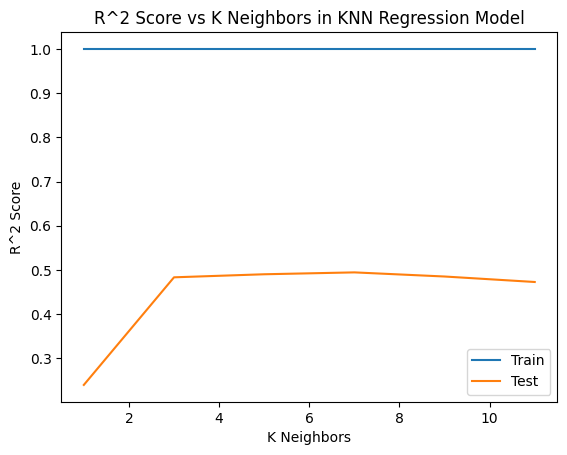

In [34]:
# ScikitLearn KNN Regression (finding optimal k_neighbors):

# Let's actually create a subset of our dataframe, and see how different k_neigbors affect our R^2 score:
df_knn_small = x_tt.sample(frac=0.3, random_state=1)

# Assigning data (X) and target (y) columns:
X_knn_small = x_tt.sample(frac=0.3, random_state=1)
y_knn_small = y_tar.sample(frac=0.3, random_state=1)

print('X_knn_small shape:', X_knn_small.shape)
print('y_knn_small shape:', y_knn_small.shape)

# Let's split our dataframe into train and test sets:
X_knn_small_train, X_knn_small_test, y_knn_small_train, y_knn_small_test = train_test_split(X_knn_small, y_knn_small, test_size = 0.2, random_state=1)

print('X_knn_small_train shape:', X_knn_small_train.shape)
print('y_knn_small_train shape:', y_knn_small_train.shape)
print('X_knn_small_test shape:', X_knn_small_test.shape)
print('y_knn_small_test shape:', y_knn_small_test.shape)
print("---------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_knn_small_train)
X_knn_small_train = scaler.transform(X_knn_small_train)
X_knn_small_test = scaler.transform(X_knn_small_test)

# Running through loop:
train_scores_knn = []
test_scores_knn = []

k_values = list(range(1, 12, 2))

for k in k_values:
    
    myKNN = KNeighborsRegressor(n_neighbors=k, weights='distance')
    myKNN.fit(X_knn_small_train, y_knn_small_train)
    
    train_scores_knn.append(myKNN.score(X_knn_small_train,y_knn_small_train))
    test_scores_knn.append(myKNN.score(X_knn_small_test,y_knn_small_test))
    
    print(f'Train set R^2 score with k_value={k}: {myKNN.score(X_knn_small_train,y_knn_small_train)}')
    print(f'Test set R^2 score with k_value={k}: {myKNN.score(X_knn_small_test,y_knn_small_test)}')
    
# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs K Neighbors in KNN Regression Model")
plt.plot(k_values, train_scores_knn, label="Train")
plt.plot(k_values, test_scores_knn, label="Test")
plt.legend()
plt.xlabel("K Neighbors")
plt.ylabel("R^2 Score")
plt.show()

We can see 3-7 K-neighbors are ideal for achieving high R^2 score but it is still not sufficient. Let's move on.

### Decision Tree Regression

In [35]:
# ScikitLearn DT Regression (default values).

# Let's split our dataframe into train and test sets:
X_dt_train, X_dt_test, y_dt_train, y_dt_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_dt_train shape:', X_dt_train.shape)
print('y_dt_train shape:', y_dt_train.shape)
print('X_dt_test shape:', X_dt_test.shape)
print('y_dt_test shape:', y_dt_test.shape)
print("----------------------------------------------------------------------------------------------------------")

# 1. Instantiate the model:
myDT = DecisionTreeRegressor()

# 2. Fit the model:
myDT.fit(X_dt_train, y_dt_train)

# 3. Make prediction (will use it for mae):
y_dt_test_pred = myDT.predict(X_dt_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_dt_test, y_dt_test_pred))
print("The mean value of the price column is: ", y_dt_test.mean())
print("The train set R^2 of our model is: ", round(myDT.score(X_dt_train,y_dt_train),4))
print("The test set R^2 of our model is: ", round(myDT.score(X_dt_test,y_dt_test),4))

# Saving our model:
joblib.dump(myDT, 'myDT.pkl')

myDT.get_depth()

X_dt_train shape: (3066, 18)
y_dt_train shape: (3066, 1)
X_dt_test shape: (767, 18)
y_dt_test shape: (767, 1)
----------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2.6671707953063883
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  1.0
The test set R^2 of our model is:  0.8313


25

Offers highest R^2 score from all the regression tasks we have looked at so far with a `depth=25` and a `R^2=0.8213`.

### Decision Tree Regression 

The mean absolute error of our model with max_depth=3: 6.113409086636457
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=3: 0.3775472063205113
Test set R^2 score with max_depth=3: 0.40105604214102264

The mean absolute error of our model with max_depth=5: 4.445472762238456
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=5: 0.6297295477022132
Test set R^2 score with max_depth=5: 0.6169524234697723



The mean absolute error of our model with max_depth=7: 3.275709272846417
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=7: 0.7879436392492847
Test set R^2 score with max_depth=7: 0.7672991171281143

The mean absolute error of our model with max_depth=10: 2.5744595739881007
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=10: 0.9474642359212073
Test set R^2 score with max_depth=10: 0.8443030019766927

The mean absolute error of our model with max_depth=15: 2.7152475873905093
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=15: 0.9942307239261489
Test set R^2 score with max_depth=15: 0.8197576883484198

The mean absolute error of our model with max_depth=20: 2.783758315836706
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
Train set R^2 score with max_depth=20

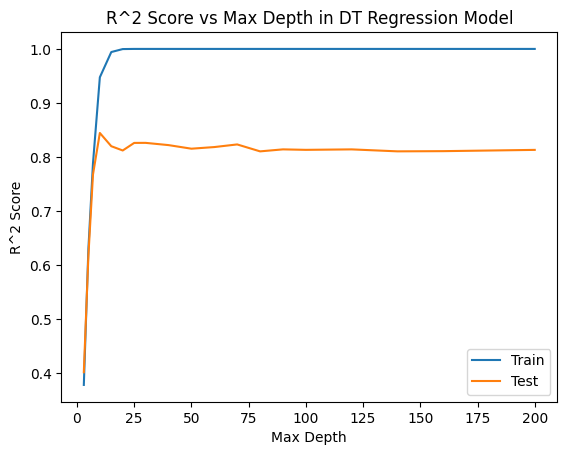

In [36]:
# ScikitLearn DT Regression (finding optimal max_depth):

# Running through loop:
train_scores_dt = []
test_scores_dt = []

depth = [3,5,7,10,15,20,25,30,40,50,60,70,80,90,100,120,140,160,200]

for d in depth:
    # 1. Instantiate the model:
    myDT = DecisionTreeRegressor(max_depth=d)

    # 2. Fit the model:
    myDT.fit(X_dt_train, y_dt_train)
    
    train_scores_dt.append(myDT.score(X_dt_train,y_dt_train))
    test_scores_dt.append(myDT.score(X_dt_test,y_dt_test))
    
    # 3. Make prediction (will use it for mae):
    y_dt_test_pred = myDT.predict(X_dt_test)

    # 4. R^2 score check:
    print(f'The mean absolute error of our model with max_depth={d}: {mae(y_dt_test, y_dt_test_pred)}')
    print("The mean value of the price column is: ", y_dt_test.mean())
    print(f'Train set R^2 score with max_depth={d}: {myDT.score(X_dt_train,y_dt_train)}')
    print(f'Test set R^2 score with max_depth={d}: {myDT.score(X_dt_test,y_dt_test)}')
    print()

# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs Max Depth in DT Regression Model")
plt.plot(depth, train_scores_dt, label="Train")
plt.plot(depth, test_scores_dt, label="Test")
plt.legend()
plt.xlabel("Max Depth")
plt.ylabel("R^2 Score")
plt.show()

We can see that at the `max_depth=10` we get highest possible R^2 score for our test set which is better than the default `depth=25`.

#### LinearSVR Regression 

In [37]:
# ScikitLearn LinearSVR Regression (default values):

X_svr_train, X_svr_test, y_svr_train, y_svr_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_svr_train shape:', X_svr_train.shape)
print('y_svr_train shape:', y_svr_train.shape)
print('X_svr_test shape:', X_svr_test.shape)
print('y_svr_test shape:', y_svr_test.shape)
print("--------------------------------------------------------------------------------------------------------------------------------")

# Scale and Transform data:
scaler = StandardScaler()
scaler.fit(X_svr_train)
X_svr_train = scaler.transform(X_svr_train)
X_svr_test = scaler.transform(X_svr_test)

# 1. Instantiate the model:
mySVR = LinearSVR()

# 2. Fit the model:
mySVR.fit(X_svr_train, y_svr_train)
 
# 3. Make prediction (will use it for mae):
y_svr_test_pred = mySVR.predict(X_svr_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_svr_test, y_svr_test_pred))
print("The mean value of the price column is: ", y_svr_test.mean())
print("The train set R^2 of our model is: ", round(mySVR.score(X_svr_train,y_svr_train),4))
print("The test set R^2 of our model is: ", round(mySVR.score(X_svr_test,y_svr_test),4))

X_svr_train shape: (3066, 18)
y_svr_train shape: (3066, 1)
X_svr_test shape: (767, 18)
y_svr_test shape: (767, 1)
--------------------------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  7.17280111463947
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.122
The test set R^2 of our model is:  0.1249


#### LinearSVR Regression: Hyperparameter Optimization

Result for the C= 1
The mean absolute error of our model is:  7.17805344591614
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1244
The test set R^2 of our model is:  0.1256

Result for the C= 6
The mean absolute error of our model is:  7.161500109166928
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1219
The test set R^2 of our model is:  0.1254

Result for the C= 11
The mean absolute error of our model is:  7.162436374071293
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1195
The test set R^2 of our model is:  0.1224

Result for the C= 16
The mean absolute error of our model is:  7.163015251894377
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.1175
The test set R^2 of our model is:  0.1227

Result for the 

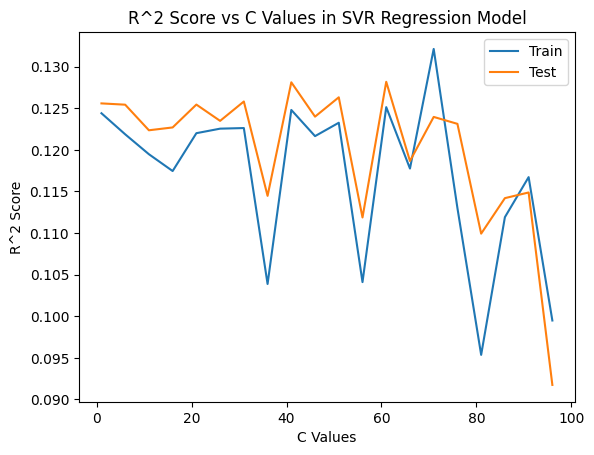

In [38]:
# ScikitLearn LinearSVR Regression (custom c_values):

C_values = range(1,100,5)

train_scores_svr = []
test_scores_svr = []

for c in C_values:

    # 1. Instantiate the model
    mySVR = LinearSVR(C=c)

    # 2. Fit the model
    mySVR.fit(X_svr_train, y_svr_train)

    train_scores_svr.append(mySVR.score(X_svr_train,y_svr_train))
    test_scores_svr.append(mySVR.score(X_svr_test,y_svr_test))
    
    # 3. Make prediction (will use it for mae)
    y_svr_test_pred = mySVR.predict(X_svr_test)

    # 4. R^2 score check:
    print("Result for the C=", c)
    print("The mean absolute error of our model is: ", mae(y_svr_test, y_svr_test_pred))
    print("The mean value of the price column is: ", y_svr_test.mean())
    print("The train set R^2 of our model is: ", round(mySVR.score(X_svr_train,y_svr_train),4))
    print("The test set R^2 of our model is: ", round(mySVR.score(X_svr_test,y_svr_test),4))
    print()
    
# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs C Values in SVR Regression Model")
plt.plot(C_values, train_scores_svr, label="Train")
plt.plot(C_values, test_scores_svr, label="Test")
plt.legend()
plt.xlabel("C Values")
plt.ylabel("R^2 Score")
plt.show()

We can see we achieved better accuracy with other methods.

#### RandomForest Regression

In [39]:
# ScikitLearn RandomForest Regression (default values):

# Let's split our dataframe into train and test sets:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_rf_train shape:', X_rf_train.shape)
print('y_rf_train shape:', y_rf_train.shape)
print('X_rf_test shape:', X_rf_test.shape)
print('y_rf_test shape:', y_rf_test.shape)
print("-------------------------------------------------------------------------------------------------------------")

# 1. Instantiate the model:
myRF = RandomForestRegressor(random_state=1)

# 2. Fit the model:
myRF.fit(X_rf_train, y_rf_train)

# 3. Make prediction (will use it for mae):
y_rf_test_pred = myRF.predict(X_rf_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_rf_test, y_rf_test_pred))
print("The mean value of the price column is: ", y_rf_test.mean())
print("The train set R^2 of our model is: ", round(myRF.score(X_rf_train,y_rf_train),4))
print("The test set R^2 of our model is: ", round(myRF.score(X_rf_test,y_rf_test),4))

# Saving our model:
joblib.dump(myRF, 'myRF_default.pkl')

X_rf_train shape: (3066, 18)
y_rf_train shape: (3066, 1)
X_rf_test shape: (767, 18)
y_rf_test shape: (767, 1)
-------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2.2559445110821374
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.9835
The test set R^2 of our model is:  0.8908


['myRF_default.pkl']

RandomForest Regression has offered us the best accuracy so far with `R^2=0.8908`.

In [40]:
# Let's see feature importances of our model:
feat_importances = pd.Series(myRF.feature_importances_, index=X_rf_train.columns)

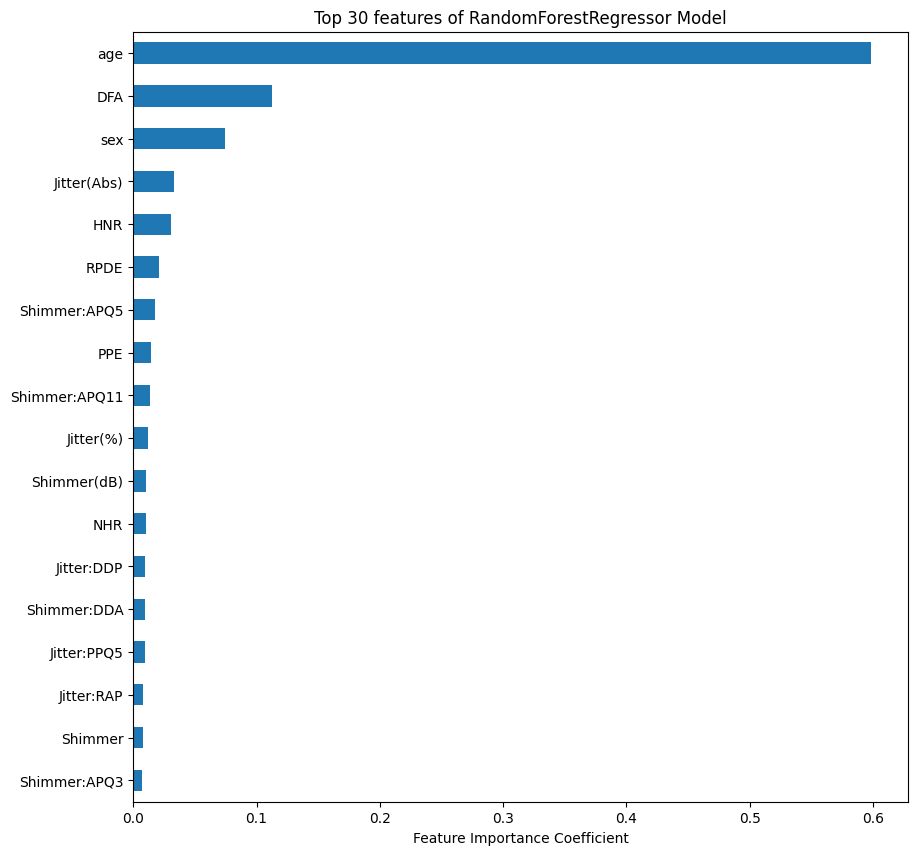

In [41]:
# Top 30 features:
fig, ax = plt.subplots()
feat_importances.sort_values(ascending=False).head(30).plot(kind='barh', x='x', y='y', ax=ax, figsize=(10,10))
plt.gca().invert_yaxis()
plt.title('Top 30 features of RandomForestRegressor Model')
plt.xlabel('Feature Importance Coefficient')
plt.show()

We can clearly see that the `age` column is the most important in predicting the Parkinson's Telemonitoring value followed by `DFA` and `sex`.

Conversely, `Shimmer:APQ3`, `Shimmer`, and `Jitter:RAP` offer the lease importance from our features.

In [42]:
# Dropping 'Shimmer, Shimmer:APQ3, Jitter:RAP' column:
data_work_new = x_tt.drop(['Shimmer','Shimmer:APQ3','Jitter:RAP'], axis=1)
data_work_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3833 entries, 0 to 5874
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   age            3833 non-null   int64  
 1   Jitter(%)      3833 non-null   float64
 2   Jitter(Abs)    3833 non-null   float64
 3   Jitter:PPQ5    3833 non-null   float64
 4   Jitter:DDP     3833 non-null   float64
 5   Shimmer(dB)    3833 non-null   float64
 6   Shimmer:APQ5   3833 non-null   float64
 7   Shimmer:APQ11  3833 non-null   float64
 8   Shimmer:DDA    3833 non-null   float64
 9   NHR            3833 non-null   float64
 10  HNR            3833 non-null   float64
 11  RPDE           3833 non-null   float64
 12  DFA            3833 non-null   float64
 13  PPE            3833 non-null   float64
 14  sex            3833 non-null   int64  
dtypes: float64(13), int64(2)
memory usage: 479.1 KB


In [43]:
# Let's now convert our categorical columns into dummy variables:
df_work3_new = pd.get_dummies(data_work_new)
print("The shape of our new dataframe: ", df_work3_new.shape)

# Let's remove all the spaces within column names and make them all lowercase (in case if there are some uppercase letters):
df_work3_new.columns = df_work3_new.columns.str.replace(' ', '_')
df_work3_new.columns = map(str.lower, df_work3_new.columns)

# Resetting index:
df_work3_new = df_work3_new.reset_index().drop(columns = ['index']).copy()
x_tt = df_work3_new

The shape of our new dataframe:  (3833, 15)


Checking RF model again with new dataset.

In [44]:
# Let's split our dataframe into train and test sets:
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(x_tt, y_tar, test_size = 0.2, random_state=1)

print('X_rf_train shape:', X_rf_train.shape)
print('y_rf_train shape:', y_rf_train.shape)
print('X_rf_test shape:', X_rf_test.shape)
print('y_rf_test shape:', y_rf_test.shape)
print("-------------------------------------------------------------------------------------------------------------")

# 1. Instantiate the model:
myRF = RandomForestRegressor(random_state=1)

# 2. Fit the model:
myRF.fit(X_rf_train, y_rf_train)

# 3. Make prediction (will use it for mae):
y_rf_test_pred = myRF.predict(X_rf_test)

# 4. R^2 score check:
print("The mean absolute error of our model is: ", mae(y_rf_test, y_rf_test_pred))
print("The mean value of the price column is: ", y_rf_test.mean())
print("The train set R^2 of our model is: ", round(myRF.score(X_rf_train,y_rf_train),4))
print("The test set R^2 of our model is: ", round(myRF.score(X_rf_test,y_rf_test),4))

# Saving our model:
joblib.dump(myRF, 'myRF_default_new.pkl')

X_rf_train shape: (3066, 15)
y_rf_train shape: (3066, 1)
X_rf_test shape: (767, 15)
y_rf_test shape: (767, 1)
-------------------------------------------------------------------------------------------------------------
The mean absolute error of our model is:  2.2561183181225553
The mean value of the price column is:  total_UPDRS    29.358301
dtype: float64
The train set R^2 of our model is:  0.9834
The test set R^2 of our model is:  0.8909


['myRF_default_new.pkl']

We can see it didn't change the accuracy significantly by dropping redundant columns. RandomForest offers us the highest accuracy so far.

#### RandomForestRegressor: Hyperparameter Optimization

X_rf_train_small shape: (920, 15)
y_rf_train_small shape: (920, 1)
X_rf_test_small shape: (230, 15)
y_rf_test_small shape: (230, 1)
-------------------------------------------------------------------------------------------------------------
Train set R^2 score with n_estimators=10: 0.9547541390347035
Test set R^2 score with n_estimators=10: 0.8178311331710443

Train set R^2 score with n_estimators=30: 0.9682907870653648
Test set R^2 score with n_estimators=30: 0.8362082511300986

Train set R^2 score with n_estimators=50: 0.9701849235438134
Test set R^2 score with n_estimators=50: 0.833913024326202

Train set R^2 score with n_estimators=70: 0.9711489622052657
Test set R^2 score with n_estimators=70: 0.8415404214690909

Train set R^2 score with n_estimators=100: 0.9722584737751544
Test set R^2 score with n_estimators=100: 0.8455852939364045

Train set R^2 score with n_estimators=150: 0.9717851144103354
Test set R^2 score with n_estimators=150: 0.8416928156188148

Train set R^2 score wit

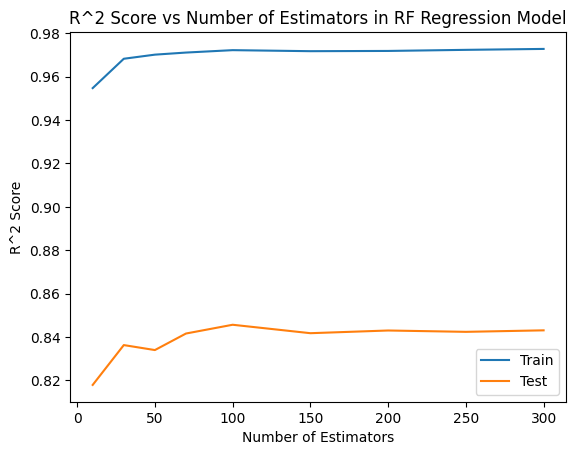

In [45]:
# Let's actually create a subset of our dataframe, and see how different hyperparameters of RandomForestRegressor model affect our R^2 score:
x_RF = x_tt.sample(frac=0.3, random_state=1)
y_RF = y_tar.sample(frac=0.3, random_state=1)

# Let's now split the data into train and test sets:
X_rf_train_small, X_rf_test_small, y_rf_train_small, y_rf_test_small = train_test_split(x_RF, y_RF, test_size = 0.2, random_state=1)

print('X_rf_train_small shape:', X_rf_train_small.shape)
print('y_rf_train_small shape:', y_rf_train_small.shape)
print('X_rf_test_small shape:', X_rf_test_small.shape)
print('y_rf_test_small shape:', y_rf_test_small.shape)
print("-------------------------------------------------------------------------------------------------------------")


# Let's now run the RF model with different n_estimators and see how our R^2 scores change:
train_scores_rf = []
test_scores_rf = []

n_number = [10,30,50,70,100,150,200,250,300] 

for n in n_number:
    
    myRF = RandomForestRegressor(n_estimators=n, random_state=1)
    myRF.fit(X_rf_train_small, y_rf_train_small)
    
    train_scores_rf.append(myRF.score(X_rf_train_small, y_rf_train_small))
    test_scores_rf.append(myRF.score(X_rf_test_small, y_rf_test_small))
    
    print(f'Train set R^2 score with n_estimators={n}: {myRF.score(X_rf_train_small, y_rf_train_small)}')
    print(f'Test set R^2 score with n_estimators={n}: {myRF.score(X_rf_test_small, y_rf_test_small)}')
    print()

# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs Number of Estimators in RF Regression Model")
plt.plot(n_number, train_scores_rf, label="Train")
plt.plot(n_number, test_scores_rf, label="Test")
plt.legend()
plt.xlabel("Number of Estimators")
plt.ylabel("R^2 Score")
plt.show()

We can see that the peak accuracy is achieved with n=100 after which it is more computationally heavy and doesn't yield significant accuracy. The default value achieves the best results so we will keep that for now.

Train set R^2 score with max_depth=1: 0.1151726527105188
Test set R^2 score with max_depth=1: 0.12838921834550565

Train set R^2 score with max_depth=6: 0.8390801990723926
Test set R^2 score with max_depth=6: 0.7859680683362635

Train set R^2 score with max_depth=11: 0.9633300033240942
Test set R^2 score with max_depth=11: 0.8462824258460895

Train set R^2 score with max_depth=16: 0.9720519689603854
Test set R^2 score with max_depth=16: 0.8455108727863038

Train set R^2 score with max_depth=21: 0.9722701824257138
Test set R^2 score with max_depth=21: 0.8451497090755108

Train set R^2 score with max_depth=26: 0.9722584737751544
Test set R^2 score with max_depth=26: 0.8455852939364045

Train set R^2 score with max_depth=31: 0.9722584737751544
Test set R^2 score with max_depth=31: 0.8455852939364045

Train set R^2 score with max_depth=36: 0.9722584737751544
Test set R^2 score with max_depth=36: 0.8455852939364045

Train set R^2 score with max_depth=41: 0.9722584737751544
Test set R^2 scor

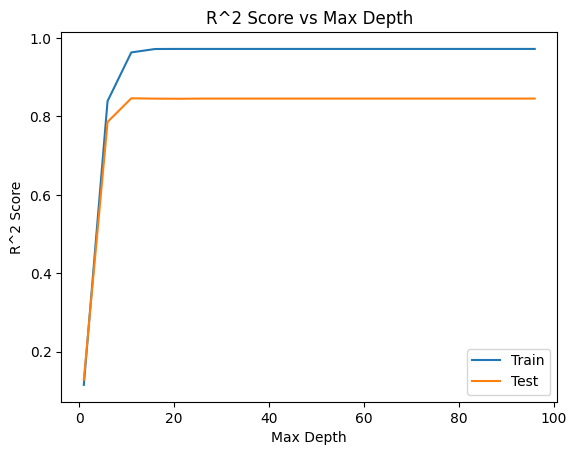

In [46]:
# Let's now run the RF model with different max_depth values and see how our R^2 scores change:
train_scores_rf_md = []
test_scores_rf_md = []

depth = list(range(1,100,5)) 

for d in depth:
    
    myRF = RandomForestRegressor(max_depth=d, random_state=1)
    myRF.fit(X_rf_train_small, y_rf_train_small)
    
    train_scores_rf_md.append(myRF.score(X_rf_train_small, y_rf_train_small))
    test_scores_rf_md.append(myRF.score(X_rf_test_small, y_rf_test_small))
    
    print(f'Train set R^2 score with max_depth={d}: {myRF.score(X_rf_train_small, y_rf_train_small)}')
    print(f'Test set R^2 score with max_depth={d}: {myRF.score(X_rf_test_small, y_rf_test_small)}')
    print()
    
# Let's plot our results:
plt.figure()
plt.title("R^2 Score vs Max Depth")
plt.plot(depth, train_scores_rf_md, label="Train")
plt.plot(depth, test_scores_rf_md, label="Test")
plt.legend()
plt.xlabel("Max Depth")
plt.ylabel("R^2 Score")
plt.show()

The default depth also offers a better accuracy so we will not consider these options.

We will consider the RandomForest Regressor to be our best ML model for Parkinson's Telemonitoring estimation for the given Dataset with an accuracy of `R^2=0.8909` after dropping the 3 least relevant columns.

#### Pycaret

In [47]:
from pycaret.regression import *

#merging data columns and target columns
x_tt['total_UPDRS'] = y_tar['total_UPDRS']
#dropping nan values
x_tt.dropna(subset='total_UPDRS', inplace=True)

#setup
reg1 = setup(x_tt, target = 'total_UPDRS', session_id=123, log_experiment=True, experiment_name='parkinsons')

,Description,Value
0,Session id,123
1,Target,total_UPDRS
2,Target type,Regression
3,Original data shape,"(2657, 16)"
4,Transformed data shape,"(2657, 16)"
5,Transformed train set shape,"(1859, 16)"
6,Transformed test set shape,"(798, 16)"
7,Numeric features,15
8,Preprocess,True
9,Imputation type,simple


In [48]:
#finding best model
best_model = compare_models(fold=5)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:46:12
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Linear Regression


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.2746,37.0966,6.0766,0.5940,0.2296,0.1824,0.1220
rf,Random Forest Regressor,4.4946,39.9594,6.3094,0.5624,0.2376,0.1919,0.3300
catboost,CatBoost Regressor,4.7722,41.2700,6.4114,0.5486,0.2433,0.2030,1.1420
lightgbm,Light Gradient Boosting Machine,4.7450,41.6819,6.4490,0.5429,0.2443,0.2026,0.1200
gbr,Gradient Boosting Regressor,4.9909,44.7386,6.6764,0.5104,0.2515,0.2131,0.1920
xgboost,Extreme Gradient Boosting,4.9045,45.8396,6.7592,0.4982,0.2556,0.2070,0.1260
knn,K Neighbors Regressor,4.7788,47.7047,6.8934,0.4770,0.2596,0.2041,0.0200
ada,AdaBoost Regressor,6.3433,59.9904,7.7442,0.3405,0.2878,0.2706,0.0720
lar,Least Angle Regression,7.0723,77.5225,8.7983,0.1496,0.3192,0.2937,0.0140
lr,Linear Regression,7.0749,77.5390,8.7993,0.1494,0.3192,0.2938,1.1000


As evident, the second best accuracy was offered by Random Forest regressor which is compliant with our experiments. We did not perform extra trees regressor which would have offered the highest accuracy. This satisfies our conclusion on the best ML models to use for Parkinson's Telemonitoring.

In [49]:
#creating model
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1678,51.1951,7.1551,0.4387,0.2809,0.2411
1,4.9012,47.5207,6.8935,0.5486,0.2508,0.1933
2,4.6948,39.6628,6.2978,0.5352,0.2492,0.2151
3,4.3398,36.3013,6.0251,0.5850,0.2372,0.1977
4,4.3714,33.8325,5.8166,0.5814,0.2259,0.1881
5,5.3525,54.5717,7.3873,0.4831,0.2575,0.1999
6,4.5105,37.4256,6.1176,0.5357,0.2224,0.1773
7,4.3550,36.4538,6.0377,0.5771,0.2268,0.1852
8,4.9623,43.8288,6.6203,0.5341,0.2526,0.2152


In [50]:
lgbms = [create_model('lightgbm', learning_rate=i) for i in np.arange(0.1,1,0.1)]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1678,51.1951,7.1551,0.4387,0.2809,0.2411
1,4.9012,47.5207,6.8935,0.5486,0.2508,0.1933
2,4.6948,39.6628,6.2978,0.5352,0.2492,0.2151
3,4.3398,36.3013,6.0251,0.5850,0.2372,0.1977
4,4.3714,33.8325,5.8166,0.5814,0.2259,0.1881
5,5.3525,54.5717,7.3873,0.4831,0.2575,0.1999
6,4.5105,37.4256,6.1176,0.5357,0.2224,0.1773
7,4.3550,36.4538,6.0377,0.5771,0.2268,0.1852
8,4.9623,43.8288,6.6203,0.5341,0.2526,0.2152


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.2745,50.3319,7.0945,0.4482,0.2788,0.2402
1,5.1195,50.4304,7.1014,0.5210,0.2619,0.2069
2,5.0073,45.2693,6.7282,0.4695,0.2624,0.2286
3,4.2351,33.2425,5.7656,0.6200,0.2292,0.1930
4,4.6782,37.1332,6.0937,0.5405,0.2330,0.1988
5,5.5211,57.8321,7.6047,0.4522,0.2678,0.2056
6,4.7153,41.7274,6.4597,0.4823,0.2396,0.1884
7,4.5377,39.3253,6.2710,0.5438,0.2354,0.1930
8,5.3792,50.4465,7.1026,0.4637,0.2686,0.2320


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.4589,55.4527,7.4467,0.3920,0.2855,0.2492
1,5.2874,53.0912,7.2864,0.4957,0.2643,0.2064
2,5.3392,50.5744,7.1116,0.4073,0.2724,0.2380
3,4.4866,37.6015,6.1320,0.5701,0.2425,0.2010
4,5.0024,42.1059,6.4889,0.4790,0.2493,0.2134
5,5.5741,60.7996,7.7974,0.4241,0.2766,0.2087
6,4.7882,42.0013,6.4808,0.4789,0.2391,0.1901
7,4.6164,40.4517,6.3602,0.5308,0.2386,0.1956
8,5.4745,53.8413,7.3377,0.4276,0.2745,0.2349


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.5767,56.8113,7.5373,0.3771,0.2933,0.2527
1,5.3570,54.2775,7.3673,0.4845,0.2744,0.2097
2,5.1456,46.1423,6.7928,0.4593,0.2682,0.2357
3,4.6016,38.8200,6.2306,0.5562,0.2429,0.2064
4,5.0247,43.4064,6.5884,0.4629,0.2513,0.2133
5,5.5402,58.1050,7.6227,0.4496,0.2717,0.2073
6,4.9907,44.1582,6.6452,0.4522,0.2454,0.1978
7,4.7775,44.1346,6.6434,0.4881,0.2488,0.1992
8,5.4084,51.3793,7.1679,0.4538,0.2725,0.2341


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.6628,57.3186,7.5709,0.3716,0.3002,0.2606
1,5.5282,57.7662,7.6004,0.4513,0.2751,0.2120
2,5.5011,51.9647,7.2087,0.3910,0.2806,0.2470
3,4.7670,41.0600,6.4078,0.5306,0.2549,0.2165
4,4.9307,40.9987,6.4030,0.4927,0.2465,0.2053
5,5.6407,61.8653,7.8655,0.4140,0.2796,0.2129
6,5.2873,49.6588,7.0469,0.3839,0.2691,0.2114
7,5.2669,49.8072,7.0574,0.4222,0.2690,0.2237
8,5.7682,59.3154,7.7017,0.3694,0.2895,0.2463


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.6767,61.6316,7.8506,0.3243,0.3034,0.2547
1,5.6828,61.6447,7.8514,0.4145,0.2888,0.2262
2,5.8088,57.2292,7.5650,0.3293,0.2965,0.2609
3,5.0088,44.5157,6.6720,0.4911,0.2658,0.2279
4,5.5306,50.0098,7.0718,0.3812,0.2733,0.2352
5,5.6944,59.1579,7.6914,0.4396,0.2760,0.2126
6,5.1845,49.9696,7.0689,0.3801,0.2618,0.2039
7,4.9635,47.5827,6.8980,0.4481,0.2615,0.2037
8,5.9625,60.4980,7.7780,0.3569,0.2891,0.2484


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3843,75.5572,8.6924,0.1716,0.3387,0.2844
1,6.0928,67.4014,8.2098,0.3598,0.3073,0.2452
2,6.1421,66.3068,8.1429,0.2229,0.3126,0.2771
3,5.5875,52.1277,7.2200,0.4040,0.2814,0.2444
4,5.3481,53.2165,7.2950,0.3415,0.2796,0.2267
5,6.0298,62.2341,7.8889,0.4105,0.2843,0.2280
6,5.4211,54.8370,7.4052,0.3197,0.2762,0.2185
7,5.2150,50.5882,7.1125,0.4132,0.2661,0.2133
8,6.0446,69.0945,8.3123,0.2655,0.3085,0.2572


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.7807,82.5241,9.0843,0.0952,0.3575,0.3142
1,5.6081,55.2977,7.4362,0.4748,0.2728,0.2232
2,5.9543,61.7124,7.8557,0.2768,0.3050,0.2643
3,5.0789,46.2846,6.8033,0.4708,0.2753,0.2296
4,5.8325,58.2652,7.6332,0.2791,0.2873,0.2498
5,6.4293,69.7422,8.3512,0.3394,0.2990,0.2472
6,5.6633,55.9650,7.4810,0.3057,0.2837,0.2282
7,5.6474,58.3098,7.6361,0.3236,0.2955,0.2288
8,5.9776,65.1792,8.0734,0.3071,0.3067,0.2602


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.2941,86.9337,9.3238,0.0469,0.3677,0.3203
1,5.9457,62.5726,7.9103,0.4057,0.3077,0.2391
2,5.8193,58.3479,7.6386,0.3162,0.2984,0.2609
3,5.5165,52.7944,7.2660,0.3964,0.2893,0.2439
4,6.3670,66.3300,8.1443,0.1793,0.3048,0.2649
5,6.7418,85.7195,9.2585,0.1880,0.3444,0.2542
6,6.7093,75.4022,8.6834,0.0645,0.3309,0.2672
7,6.2279,67.5688,8.2200,0.2162,0.3116,0.2600
8,6.7276,79.8117,8.9337,0.1515,0.3387,0.2864


In [51]:
print(len(lgbms))

9


In [52]:
#tune hyperparameters
tuned_lightgbm = tune_model(lightgbm, n_iter=50, optimize = 'MAE')

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,14:47:37
Status,. . . . . . . . . . . . . . . . . .,Searching Hyperparameters
Estimator,. . . . . . . . . . . . . . . . . .,Light Gradient Boosting Machine


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1917,49.1109,7.0079,0.4616,0.2745,0.2368
1,4.8447,46.7027,6.8339,0.5564,0.2489,0.1950
2,4.4731,36.2912,6.0242,0.5747,0.2430,0.2085
3,4.1831,31.0938,5.5762,0.6445,0.2202,0.1873
4,4.3180,33.6797,5.8034,0.5833,0.2241,0.1856
5,5.3335,53.5017,7.3145,0.4932,0.2558,0.2008
6,4.4330,38.7740,6.2269,0.5189,0.2254,0.1751
7,4.3378,37.3286,6.1097,0.5670,0.2293,0.1826
8,4.9609,43.0653,6.5624,0.5422,0.2507,0.2145


Fitting 10 folds for each of 50 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


In [53]:
tuned_lightgbm

LGBMRegressor(bagging_fraction=0.9, bagging_freq=0, feature_fraction=0.6,
              learning_rate=0.05, min_child_samples=26, min_split_gain=0.6,
              n_estimators=160, n_jobs=-1, num_leaves=200, random_state=123,
              reg_alpha=0.2, reg_lambda=0.005)

We can see that the best amount of n_estimators=160 which is very close to our findings.

In [54]:
dt = create_model('dt')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.8072,105.2028,10.2568,-0.1534,0.3848,0.3019
1,5.7727,80.5341,8.9741,0.2351,0.3239,0.2298
2,4.8041,62.3787,7.8980,0.2690,0.2904,0.2255
3,5.6114,70.5874,8.4016,0.1930,0.3036,0.2366
4,5.1189,59.8785,7.7381,0.2591,0.2907,0.2210
5,6.5938,100.5067,10.0253,0.0479,0.3637,0.2643
6,6.0488,73.2927,8.5611,0.0907,0.3253,0.2406
7,5.8499,78.1412,8.8397,0.0936,0.3306,0.2410
8,5.3604,68.3285,8.2661,0.2736,0.3095,0.2299


In [55]:
#with n_estimators=160
bagged_dt = ensemble_model(dt, n_estimators=160)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1873,53.7738,7.3331,0.4104,0.2845,0.2426
1,4.6189,47.4229,6.8864,0.5496,0.2443,0.1778
2,4.2295,36.6433,6.0534,0.5706,0.2347,0.1919
3,4.1392,32.8119,5.7282,0.6249,0.2226,0.1845
4,3.9629,30.9644,5.5646,0.6169,0.2127,0.1685
5,4.8294,44.5881,6.6774,0.5776,0.2306,0.1790
6,4.3013,39.9364,6.3195,0.5045,0.2325,0.1722
7,4.1698,36.1684,6.0140,0.5805,0.2248,0.1751
8,4.6507,39.3079,6.2696,0.5821,0.2417,0.2052


In [56]:
boosted_dt = ensemble_model(dt, method = 'Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,5.1449,60.7215,7.7924,0.3343,0.3028,0.2425
1,4.6291,55.4522,7.4466,0.4733,0.2657,0.1799
2,3.9807,37.9522,6.1605,0.5552,0.2348,0.1792
3,4.1200,37.8221,6.1500,0.5676,0.2310,0.1787
4,3.9685,34.6423,5.8858,0.5714,0.2257,0.1688
5,4.6614,45.1109,6.7165,0.5727,0.2381,0.1760
6,4.4182,47.9660,6.9258,0.4049,0.2492,0.1798
7,4.1804,47.1353,6.8655,0.4532,0.2523,0.1722
8,5.2040,61.4116,7.8366,0.3471,0.2922,0.2250
